#### NOVA IMS / BSc in Data Science / Big Data Analysis 2024/2025
# <b>Group Project
#### Notebook `Musical Data`

#### Group:
- `Laura Matias (20221836)`
- `Marta Almendra (20221878)`
- `Matilde Casimiro (20221940)` 
- `Teresa Simão (20221873)` 

#### Dataset obtained from:
https://www.kaggle.com/datasets/abdulszz/spotify-most-streamed-songs/data

#### Definition of the problem and objectives

This notebook provides an in-depth study and examination of a dataset that has thorough information on some of the most played songs on Spotify, as well as additional insights from other major streaming services such as Apple Music, Deezer, and Shazam. It is useful for music analysts, data scientists, and machine learning professionals who want to investigate the trends and features of popular music recordings.

Main Objectives:
- Analyze artists and trends in popular music over time
- Song exploration
- Streaming patterns
- Analyze timeline influence
- Study the correlation between musical attributes and song popularity
- Predict song popularity based on attributes, by leveraging machine learning algorithms


We used many strategies to achieve our goals, keeping in mind that the code should work for large databases with multiple partitions.

#### Import Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
import seaborn as sns

from operator import add
from functools import reduce

from pyspark.sql.functions import col, when, mean, count , udf, monotonically_increasing_id, abs
from pyspark.sql.types import FloatType, StringType, DoubleType, IntegerType, StructType, StructField
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark.sql import Window

from pyspark.ml import feature
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Normalizer, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.stat import Correlation
import pyspark.ml.feature as MF

from sklearn.metrics import roc_curve, auc

#### Import the Data

In [0]:
file_location = "/FileStore/tables/Spotify_Most_Streamed_Songs.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
music = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(music)

track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4,Not Found
LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4,https://i.scdn.co/image/ab67616d0000b2730656d5ce813ca3cc4b677e05
vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6,https://i.scdn.co/image/ab67616d0000b273e85259a1cae29a8d91f2093d
Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15,https://i.scdn.co/image/ab67616d0000b273e787cffec20aa2a396a61647
WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6,https://i.scdn.co/image/ab67616d0000b273ab5c9cd818ad6ed3e9b79cd1
Sprinter,"Dave, Central Cee",2,2023,6,1,2186,91,183706234,67,213,88,17,946,141,C#,Major,92,66,58,19,0,8,24,https://i.scdn.co/image/ab67616d0000b273e3a09a9ae3f1fa102c110e60
Ella Baila Sola,"Eslabon Armado, Peso Pluma",2,2023,3,16,3090,50,725980112,34,222,43,13,418,148,F,Minor,67,83,76,48,0,8,3,https://i.scdn.co/image/ab67616d0000b2732071a0c79802d9375a53bfef
Columbia,Quevedo,1,2023,7,7,714,43,58149378,25,89,30,13,194,100,F,Major,67,26,71,37,0,11,4,https://i.scdn.co/image/ab67616d0000b273a00a817b017c6f6bf8460be9
fukumean,Gunna,1,2023,5,15,1096,83,95217315,60,210,48,11,953,130,C#,Minor,85,22,62,12,0,28,9,https://i.scdn.co/image/ab67616d0000b273017d5e26552345c4b1575b6c
La Bebe - Remix,"Peso Pluma, Yng Lvcas",2,2023,3,17,2953,44,553634067,49,110,66,13,339,170,D,Minor,81,56,48,21,0,8,33,Not Found


## 1. Preprocessing 

#### 1.1. Initial look at the data

In [0]:
music.printSchema()

root
 |-- track_name: string (nullable = true)
 |-- artist(s)_name: string (nullable = true)
 |-- artist_count: string (nullable = true)
 |-- released_year: string (nullable = true)
 |-- released_month: string (nullable = true)
 |-- released_day: string (nullable = true)
 |-- in_spotify_playlists: string (nullable = true)
 |-- in_spotify_charts: string (nullable = true)
 |-- streams: string (nullable = true)
 |-- in_apple_playlists: string (nullable = true)
 |-- in_apple_charts: string (nullable = true)
 |-- in_deezer_playlists: string (nullable = true)
 |-- in_deezer_charts: string (nullable = true)
 |-- in_shazam_charts: string (nullable = true)
 |-- bpm: string (nullable = true)
 |-- key: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- danceability_%: string (nullable = true)
 |-- valence_%: string (nullable = true)
 |-- energy_%: string (nullable = true)
 |-- acousticness_%: string (nullable = true)
 |-- instrumentalness_%: string (nullable = true)
 |-- liveness_%

Features of the Dataset

Basic Track Information:
- track_name: Name of the song.
- artist(s)_name: Name of the artist(s) performing the song.
- artist_count: Number of artists contributing to the song.
- released_year, released_month, released_day: Release date details.


Streaming Metrics:

- in_spotify_playlists: Number of Spotify playlists the song is featured in.
- in_spotify_charts: Rank of the song on Spotify charts.
- streams: Total number of streams on Spotify.
- in_apple_playlists, in_apple_charts: Presence in Apple Music playlists and charts.
- in_deezer_playlists, in_deezer_charts: Presence in Deezer playlists and charts.
- in_shazam_charts: Rank on Shazam charts.


Musical Attributes:

- bpm: Beats per minute, representing the tempo of the song.
- key: Key of the song.
- mode: Indicates whether the song is in a major or minor mode.
- danceability_%: Suitability of the song for dancing.
- valence_%: Positivity of the song’s musical content.
- energy_%: Perceived energy level of the song.
- acousticness_%: Acoustic sound presence in the song.
- instrumentalness_%: Proportion of instrumental content in the track.
- liveness_%: Presence of live performance elements.
- speechiness_%: Amount of spoken words in the song.

In [0]:
print(f"Number of rows: \n {music.count()}")
print(f"\nNumber of columns: \n {len(music.columns)}")

Number of rows: 
 953

Number of columns: 
 25


#### 1.2. Missing Values

In [0]:
# each column in music is checked for nulls
filter_conditions = [col(c).isNull() for c in music.columns]

# combine all indv column conditions using an OR (|) to create a condition that checks for nulls in any column
combined_condition = reduce(lambda x, y: x | y, filter_conditions)

# apply combined condition to filter rows that have at least one missing value and count them
rows_with_missing_values_count = music.filter(combined_condition).count()
print("Number of rows with missing values:", rows_with_missing_values_count)

Number of rows with missing values: 136


In [0]:
display(music.select([count(when(col(c).isNull(), c)).alias(c) for c in music.columns]))

track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,95,0,0,0,0,0,0,0,0,0


There 136 missing values in this dataset, and they appear only in the 'in_shazam_charts' and 'key' columns.

Decided to fill missing values in 'in_shazam_charts' variable with zero (assuming they are not in any charts), and with  N- non for the 'key' variable.


In [0]:
music = music.fillna({"in_shazam_charts": 0, "key": "N"})

#### 1.3. Duplicates

In [0]:
rows_before = music.count()
df_no_duplicates = music.dropDuplicates()
rows_after = df_no_duplicates.count()

has_duplicates = rows_before != rows_after
print("Has duplicate rows:", has_duplicates)

Has duplicate rows: False


#### 1.4. Data Type Correction

- Convert columns to integer type when possible (in exception of : track_name, artist_name , key, mode, cover_url), if it fails, convert to a float, and if that also fails, convert the non-numeric value into a 0.

In [0]:
# UDF to handle the conversion logic - apply to DataFrame columns in distributed fashion
def convert_to_int_or_float(value):
    try:
        # Try to cast to int
        return int(value)
    except (ValueError, TypeError):
        try:
            # Try to cast to float
            return float(value)
        except (ValueError, TypeError):
            # Return 0 if both casting attempts fail
            return 0

# register the UDF
convert_udf = udf(convert_to_int_or_float, IntegerType())  # can return an int, but if float needed, change IntegerType() to FloatType()

exclude_cols = ['track_name', 'artist(s)_name', 'key', 'mode', 'cover_url']
# apply UDF to each column, excluding specified ones
cols_to_convert = [
    convert_udf(col(c)).alias(c) if c not in exclude_cols else col(c)
    for c in music.columns]

music = music.select(*cols_to_convert)
music.printSchema()


root
 |-- track_name: string (nullable = true)
 |-- artist(s)_name: string (nullable = true)
 |-- artist_count: integer (nullable = true)
 |-- released_year: integer (nullable = true)
 |-- released_month: integer (nullable = true)
 |-- released_day: integer (nullable = true)
 |-- in_spotify_playlists: integer (nullable = true)
 |-- in_spotify_charts: integer (nullable = true)
 |-- streams: integer (nullable = true)
 |-- in_apple_playlists: integer (nullable = true)
 |-- in_apple_charts: integer (nullable = true)
 |-- in_deezer_playlists: integer (nullable = true)
 |-- in_deezer_charts: integer (nullable = true)
 |-- in_shazam_charts: integer (nullable = true)
 |-- bpm: integer (nullable = true)
 |-- key: string (nullable = false)
 |-- mode: string (nullable = true)
 |-- danceability_%: integer (nullable = true)
 |-- valence_%: integer (nullable = true)
 |-- energy_%: integer (nullable = true)
 |-- acousticness_%: integer (nullable = true)
 |-- instrumentalness_%: integer (nullable = tr

#### 1.5. Possible Inconsistencies

1. Tracks with 0 Streams


In [0]:
zero_streams_tracks = music.filter(F.col("streams") == 0)

print("=== Tracks with 0 Streams ===")
display(zero_streams_tracks.select("track_name", "artist(s)_name", "streams", "released_year"))


=== Tracks with 0 Streams ===


track_name,artist(s)_name,streams,released_year
Love Grows (Where My Rosemary Goes),Edison Lighthouse,0,1970


2. Tracks with negative streams

In [0]:
negative_streams_tracks = music.filter(F.col("streams") < 0)

print("=== Tracks with Negative Streams ===")
display(negative_streams_tracks.select("track_name", "artist(s)_name", "streams", "released_year"))

=== Tracks with Negative Streams ===


track_name,artist(s)_name,streams,released_year
As It Was,Harry Styles,-1781778803,2022
Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",-1486870746,2018
Starboy,"The Weeknd, Daft Punk",-1729437603,2016
Blinding Lights,The Weeknd,-591072222,2019
Heat Waves,Glass Animals,-1736991534,2020
Sweater Weather,The Neighbourhood,-2012195811,2012
STAY (with Justin Bieber),"Justin Bieber, The Kid Laroi",-1629623374,2021
Someone You Loved,Lewis Capaldi,-1407725482,2018
Watermelon Sugar,Harry Styles,-1972387174,2019
lovely - Bonus Track,"Billie Eilish, Khalid",-1939247403,2017


In [0]:
music = music.withColumn("streams", abs(music["streams"]))


3. Individual Artists with 0 Streams


In [0]:
individual_artists = music.withColumn("artist", F.explode(F.split(F.col("artist(s)_name"), ", ")))
zero_streams_individual_artists = individual_artists.filter(F.col("streams") == 0)
print("=== Individual Artists with 0 Streams ===")
display(zero_streams_individual_artists.select("artist", "streams").groupBy("artist").count())


=== Individual Artists with 0 Streams ===


artist,count
Edison Lighthouse,1


4. Collaborations with 0 Streams

In [0]:
zero_streams_collabs = music.filter(
    (F.size(F.split(F.col("artist(s)_name"), ", ")) > 1) &  
    (F.col("streams") == 0))

result = zero_streams_collabs.select("artist(s)_name")
print("=== Collaborations with 0 Streams ===")
display(result)


=== Collaborations with 0 Streams ===


artist(s)_name


## 2. Exploratory Data Analysis

#### 2.1. Descriptive Statistics

In [0]:
music.select(music.columns[0:8]).describe().show()
music.select(music.columns[9:18]).describe().show()
music.select(music.columns[19:24]).describe().show()
music.select(music.columns[25:29]).describe().show()
music.select(music.columns[30:]).describe().show()

+-------+--------------------+--------------+------------------+------------------+-----------------+------------------+--------------------+------------------+
|summary|          track_name|artist(s)_name|      artist_count|     released_year|   released_month|      released_day|in_spotify_playlists| in_spotify_charts|
+-------+--------------------+--------------+------------------+------------------+-----------------+------------------+--------------------+------------------+
|  count|                 953|           953|               953|               953|              953|               953|                 953|               953|
|   mean|            Infinity|          null|1.5561385099685205|2018.2381951731375|6.033578174186778|13.930745015739769|   5200.124868835257|12.009443861490032|
| stddev|                 NaN|          null|0.8930441928452751|11.116218075505934|3.566435132898138| 9.201949303162996|     7897.6089903751| 19.57599163605572|
|    min|"Apna Bana Le (Fr...|    

#### 2.2. Variables Distributions

2.2.1. Numerical Variables

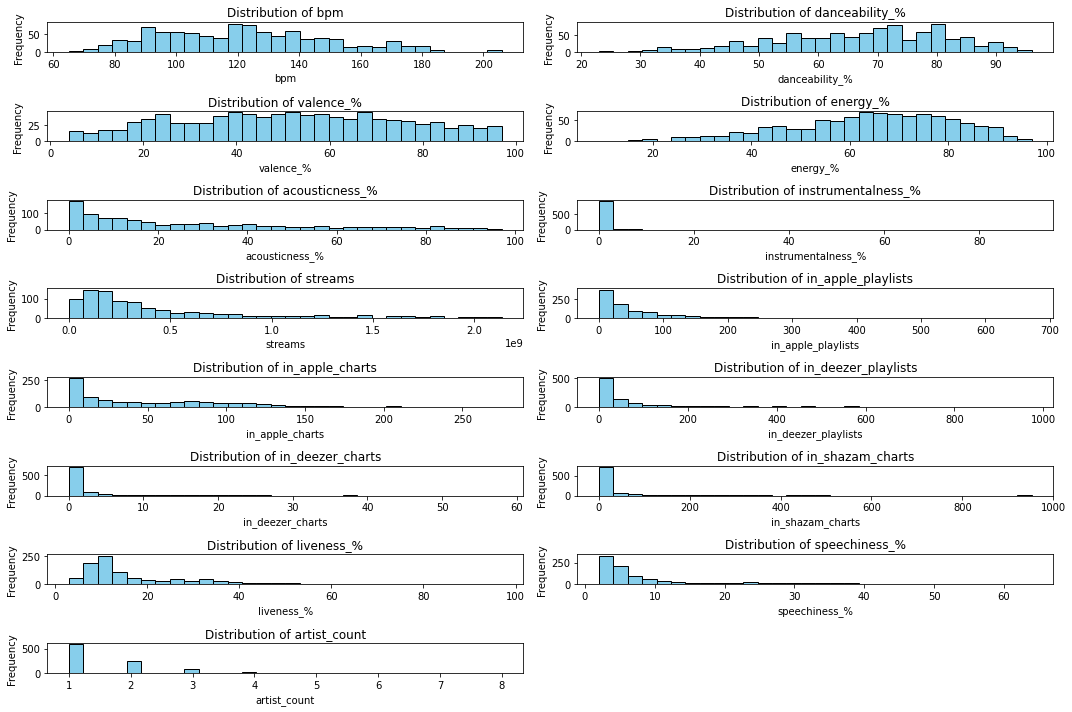

In [0]:
numerical_columns = ["bpm", "danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "streams", "in_apple_playlists", "in_apple_charts", "in_deezer_playlists", "in_deezer_charts", "in_shazam_charts", "liveness_%", "speechiness_%", "artist_count"]

# dict to store data for each numerical col
# each col's data will be retrieved and stored as a flat list
numerical_data = {}
for col in numerical_columns:
    numerical_data[col] = music.select(col).rdd.flatMap(lambda x: x).collect()

# the number of rows needed for subplots
plt.figure(figsize=(15, 10))
num_vars = len(numerical_columns)
cols = 2  
rows = (num_vars // cols) + (num_vars % cols > 0)

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)
    plt.hist(numerical_data[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

# to make sure subplots don't overlap
plt.tight_layout()
plt.show()

2.2.2. Categorical Variables

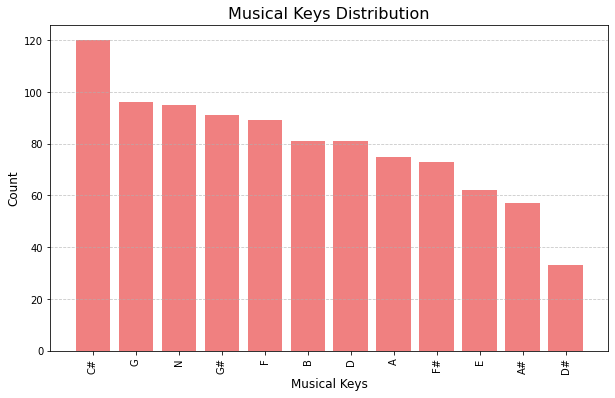

In [0]:
keys_frequency_df = music.groupBy("key").agg(F.count("*").alias("count"))

# sort keys by their frequency in descending order
keys_df = keys_frequency_df.orderBy(F.col("count"), ascending=False)
keys_data = keys_df.collect()

keys = [row['key'] for row in keys_data]
key_counts = [row['count'] for row in keys_data]

plt.figure(figsize=(10, 6))
plt.bar(keys, key_counts, color='lightcoral')
plt.title("Musical Keys Distribution", fontsize=16)
plt.xlabel("Musical Keys", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)  
plt.show()

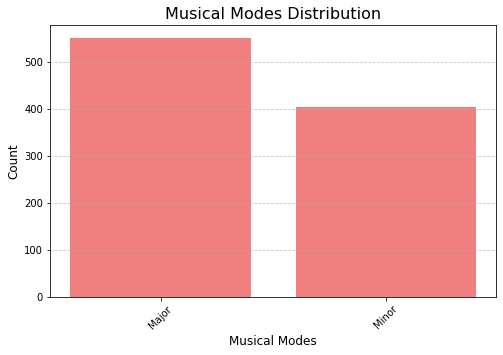

In [0]:
modes_frequency_df = music.groupBy("mode").agg(F.count("*").alias("count"))

# sort modes by their frequency in descending order
modes_df = modes_frequency_df.orderBy(F.col("count"), ascending=False)
modes_data = modes_df.collect()

modes = [row['mode'] for row in modes_data]
mode_counts = [row['count'] for row in modes_data]

plt.figure(figsize=(8, 5))
plt.bar(modes, mode_counts, color='lightcoral')
plt.title("Musical Modes Distribution", fontsize=16)
plt.xlabel("Musical Modes", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

#### 2.3. Data Exploration

##### 2.3.1 Artist Analysis

1. Most and least present artists - artists with the most and the least published songs across platforms.

In [0]:
artist_counts = music.groupBy("artist(s)_name").agg(F.count("*").alias("artist_count"))

# artists counts are sorted in descending order 
top_artists = artist_counts.rdd.takeOrdered(10, key=lambda x: -x[1])
display(top_artists)

artist(s)_name,artist_count
Taylor Swift,34
The Weeknd,22
Bad Bunny,19
SZA,19
Harry Styles,17
Kendrick Lamar,12
Morgan Wallen,11
Ed Sheeran,9
Feid,8
"Drake, 21 Savage",8


In [0]:
# artists counts are sorted in ascending order 
low_artists = artist_counts.rdd.takeOrdered(10, key=lambda x: x[1])
display(low_artists)

artist(s)_name,artist_count
YOASOBI,1
Beach House,1
"Drake, Project Pat, 21 Savage",1
Surf Curse,1
"Bad Bunny, Grupo Frontera",1
"Nicki Minaj, Aqua, Ice Spice",1
Maria Becerra,1
Cigarettes After Sex,1
Eden Muï¿½ï,1
Tones and I,1


2. Streams by Artist Count

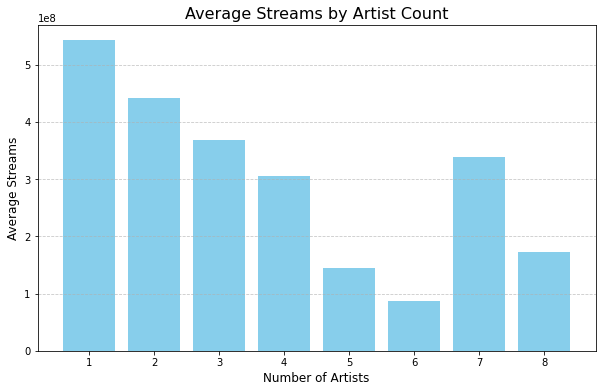

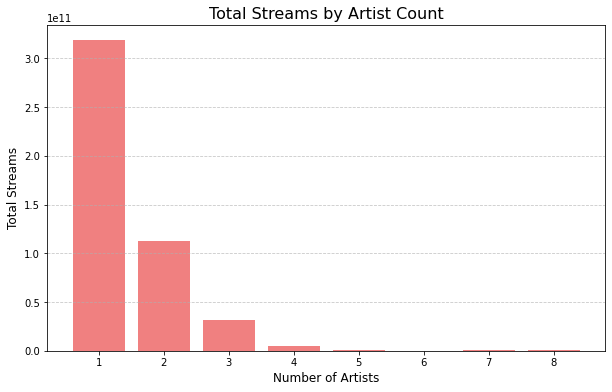

In [0]:
artist_streams_df = music.groupBy("artist_count").agg(
    F.avg("streams").alias("avg_streams"),
    F.sum("streams").alias("total_streams"))

# take() to retrieve a sample of the data for visualization (work better with large datasets) 
artist_streams_sample = artist_streams_df.take(100)

artist_counts = [row['artist_count'] for row in artist_streams_sample]
avg_streams = [row['avg_streams'] for row in artist_streams_sample]
total_streams = [row['total_streams'] for row in artist_streams_sample]

# Plot Average Streams by Artist Count
plt.figure(figsize=(10, 6))
plt.bar(artist_counts, avg_streams, color='skyblue')
plt.title("Average Streams by Artist Count", fontsize=16)
plt.xlabel("Number of Artists", fontsize=12)
plt.ylabel("Average Streams", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Total Streams by Artist Count
plt.figure(figsize=(10, 6))
plt.bar(artist_counts, total_streams, color='lightcoral')
plt.title("Total Streams by Artist Count", fontsize=16)
plt.xlabel("Number of Artists", fontsize=12)
plt.ylabel("Total Streams", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

3. Average streams per artist

In [0]:
music_rdd = music.select("artist(s)_name", "streams").rdd

# map each row into key-value pairs where the key is the artist's name and the value is a tuple (streams, 1)
artist_streams = music_rdd.map(lambda row: (row[0], (row[1], 1)))

# reduceByKey to aggregate the streams and counts for each artist
# for each, sum the streams (1st element) and the count (2nd element)
aggregated_data = artist_streams.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

# resulting RDD contains the artist's name as key and the average streams as value
average_streams = aggregated_data.mapValues(lambda x: x[0] / x[1])

average_streams_df = average_streams.map(lambda x: Row(artist=x[0], avg_streams=x[1])).toDF()
display(average_streams_df)

artist,avg_streams
"Latto, Jung Kook",1.41381703E8
Myke Towers,1.33716286E8
Olivia Rodrigo,1.0631641308571428E9
Taylor Swift,4.133428911764706E8
Bad Bunny,5.2619997931578946E8
"Dave, Central Cee",1.83706234E8
"Eslabon Armado, Peso Pluma",7.25980112E8
Quevedo,2.442678315E8
Gunna,9.5217315E7
"Peso Pluma, Yng Lvcas",5.53634067E8


4. Song Characteristics of Top and Low Artists 
- The average song tempo: determine if they produce more upbeat or slower songs.
- Song style metrics influence such as danceability, valence, energy, and so forth. 
- Acousticness and instrumentalness analysis: high acousticness VS high instrumentality


In [0]:
#for all artists
# average tempo (bpm) of each artist
avg_tempo = music.groupBy("artist(s)_name").agg(F.avg("bpm").alias("average_bpm"))

# average song style metrics (danceability, valence, energy, etc.)
song_style_metrics = music.groupBy("artist(s)_name").agg(
    F.avg("danceability_%").alias("average_danceability"),
    F.avg("valence_%").alias("average_valence"),
    F.avg("energy_%").alias("average_energy"),
    F.avg("acousticness_%").alias("average_acousticness"),
    F.avg("instrumentalness_%").alias("average_instrumentalness"))

# average acousticness vs. instrumentalness for each artist
acoustic_vs_instrumental = music.groupBy("artist(s)_name").agg(
    F.avg("acousticness_%").alias("average_acousticness"),
    F.avg("instrumentalness_%").alias("average_instrumentalness"),
    (F.when(F.avg("acousticness_%") > F.avg("instrumentalness_%"), "More Acoustic")
     .otherwise("More Instrumental")).alias("acoustic_vs_instrumental")
)

# join the DataFrames together to get the final result for all artists
final_result_all_artists = avg_tempo.join(song_style_metrics, on="artist(s)_name", how="inner") \
    .join(acoustic_vs_instrumental, on="artist(s)_name", how="inner")

In [0]:
# Extract artist names from top_artists and low_artists
top_artists_names = [row["artist(s)_name"] for row in top_artists]
low_artists_names = [row["artist(s)_name"] for row in low_artists]

# Filter the song characteristics for top and low artists
top_artists_song_char = final_result_all_artists.filter(F.col("artist(s)_name").isin(top_artists_names))
low_artists_song_char = final_result_all_artists.filter(F.col("artist(s)_name").isin(low_artists_names))


In [0]:
display(top_artists_song_char)

artist(s)_name,average_bpm,average_danceability,average_valence,average_energy,average_acousticness,average_instrumentalness,average_acousticness,average_instrumentalness,acoustic_vs_instrumental
Taylor Swift,125.52941176470588,59.76470588235294,35.55882352941177,56.794117647058826,27.88235294117647,0.6764705882352942,27.88235294117647,0.6764705882352942,More Acoustic
Feid,132.125,73.0,59.875,63.375,10.0,0.0,10.0,0.0,More Acoustic
Morgan Wallen,139.0909090909091,58.90909090909091,60.45454545454545,77.27272727272727,21.0,0.0,21.0,0.0,More Acoustic
"Drake, 21 Savage",137.875,74.0,32.0,56.875,1.375,0.0,1.375,0.0,More Acoustic
Bad Bunny,119.15789473684211,75.15789473684211,53.21052631578947,66.73684210526316,22.842105263157894,3.3157894736842106,22.842105263157894,3.3157894736842106,More Acoustic
Harry Styles,128.52941176470588,61.35294117647059,54.0,58.88235294117647,42.8235294117647,1.588235294117647,42.8235294117647,1.588235294117647,More Acoustic
Kendrick Lamar,111.58333333333333,64.58333333333333,50.0,52.916666666666664,51.25,0.08333333333333333,51.25,0.08333333333333333,More Acoustic
SZA,117.15789473684211,57.94736842105263,45.94736842105263,52.68421052631579,45.526315789473685,2.0,45.526315789473685,2.0,More Acoustic
Ed Sheeran,116.77777777777777,69.66666666666667,51.333333333333336,64.77777777777777,28.88888888888889,0.0,28.88888888888889,0.0,More Acoustic
The Weeknd,119.72727272727273,57.68181818181818,42.27272727272727,63.90909090909091,20.59090909090909,1.4090909090909092,20.59090909090909,1.4090909090909092,More Acoustic


We concluded that:

The top artists tend to have a moderate BPM (around 120), their songs are relatively danceable, a valence  reflecting a balanced mood between happy and melancholic (around the 40/50 %), a moderate energy level, and acousticness and instrumentalness on the lower side.

In [0]:

display(low_artists_song_char)

artist(s)_name,average_bpm,average_danceability,average_valence,average_energy,average_acousticness,average_instrumentalness,average_acousticness,average_instrumentalness,acoustic_vs_instrumental
YOASOBI,166.0,57.0,84.0,94.0,11.0,0.0,11.0,0.0,More Acoustic
Beach House,147.0,51.0,62.0,79.0,22.0,13.0,22.0,13.0,More Acoustic
"Drake, Project Pat, 21 Savage",146.0,85.0,22.0,37.0,13.0,0.0,13.0,0.0,More Acoustic
Surf Curse,180.0,35.0,41.0,94.0,0.0,63.0,0.0,63.0,More Instrumental
"Bad Bunny, Grupo Frontera",83.0,57.0,56.0,72.0,23.0,0.0,23.0,0.0,More Acoustic
"Nicki Minaj, Aqua, Ice Spice",144.0,77.0,75.0,58.0,52.0,0.0,52.0,0.0,More Acoustic
Maria Becerra,98.0,68.0,40.0,79.0,33.0,0.0,33.0,0.0,More Acoustic
Cigarettes After Sex,94.0,37.0,17.0,47.0,2.0,46.0,2.0,46.0,More Instrumental
Eden Muï¿½ï,189.0,55.0,86.0,44.0,40.0,0.0,40.0,0.0,More Acoustic
Tones and I,98.0,82.0,54.0,59.0,69.0,0.0,69.0,0.0,More Acoustic


We concluded that:

The low artists exhibit a slightly higher average BPM, implying faster-paced music overall, the danceability is somewhat lower , while the valence is higher, indicating that their music has a more positive emotional tone. Their songs tend to have a slitghly higher energy levels, and a comparable acousticness to the top artists. Finally the instrumentalness is significantly higher.


5. Collaboration Patterns 


In [0]:
# handle 'Tyler, The Creator' exception - create single-element array 
music_collab = music.withColumn(
    "artists_list", 
    F.when(F.col("artist(s)_name").like('Tyler, The Creator%'), 
           F.array(F.lit('Tyler, The Creator')))
    .otherwise(F.split(F.col("artist(s)_name"), ", ")))

# explode the artists_list col to create multiple rows for each artist in the list, and a  duplicate 'other_artist' col
exploded_collab = music_collab.withColumn("artist", F.explode("artists_list")) \
    .withColumn("other_artist", F.explode("artists_list"))

# filtering out rows where the artist and other_artist are same
# unique identifier for each artist pair -> sorting the names and concatenating them
collab_pairs = exploded_collab.filter(F.col("artist") != F.col("other_artist")) \
    .withColumn("artist_pair", F.concat_ws("-", F.array_sort(F.array(F.col("artist"), F.col("other_artist")))))

collab_pairs_counts = collab_pairs.groupBy("artist_pair").agg(F.count("*").alias("count"))

top_collab_pairs = collab_pairs_counts.orderBy(F.desc("count")).limit(10)

top_collab_pairs.show(truncate=False)

+-------------------------+-----+
|artist_pair              |count|
+-------------------------+-----+
|21 Savage-Drake          |20   |
|Junior H-Peso Pluma      |6    |
|Future-Metro Boomin      |6    |
|Metro Boomin-Travis Scott|6    |
|Bad Bunny-Tainy          |6    |
|Arijit Singh-Sachin-Jigar|4    |
|Don Toliver-Justin Bieber|4    |
|Dr. Dre-Snoop Dogg       |4    |
|Lil Baby-Nicki Minaj     |4    |
|Feid-Mora                |4    |
+-------------------------+-----+



##### 2.3.2. Song Analysis

1. Top 10 Streamed Songs 

In [0]:
music_rdd = music.rdd

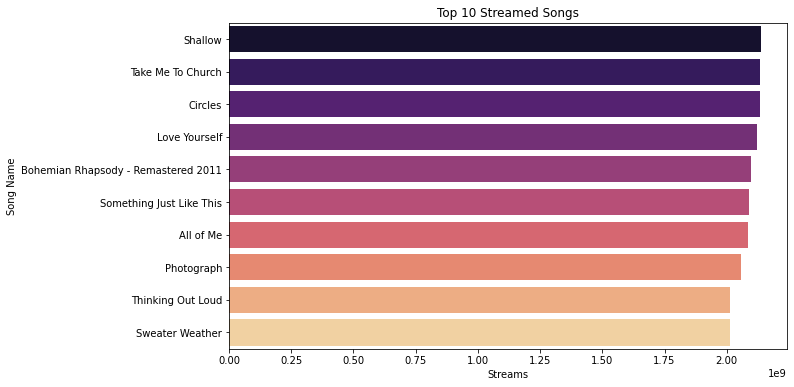

Top 10 songs in regards to streams:
1. Shallow - 2,135,620,609 streams | by Lady Gaga, Bradley Cooper
2. Take Me To Church - 2,135,158,446 streams | by Hozier
3. Circles - 2,132,335,812 streams | by Post Malone
4. Love Yourself - 2,123,309,722 streams | by Justin Bieber
5. Bohemian Rhapsody - Remastered 2011 - 2,097,956,617 streams | by Queen
6. Something Just Like This - 2,090,886,568 streams | by The Chainsmokers, Coldplay
7. All of Me - 2,086,124,197 streams | by John Legend
8. Photograph - 2,058,299,364 streams | by Ed Sheeran
9. Thinking Out Loud - 2,014,401,204 streams | by Ed Sheeran
10. Sweater Weather - 2,012,195,811 streams | by The Neighbourhood


In [0]:
# map RDD to a new structure with track name, streams, and artist(s) name as tuple elements
rdd_mapped = music_rdd.map(lambda row: (row["track_name"], row["streams"], row["artist(s)_name"]))


# to optimize performance for following repeated actions 
rdd_mapped.cache()

# sort by streams in descending order and take the top 10
top10_streams_data = rdd_mapped.sortBy(lambda x: x[1], ascending=False).take(10)
# each entry is a tuple containing track name, streams, and artist(s)
track_names = [x[0] for x in top10_streams_data]
streams = [x[1] for x in top10_streams_data]
artists = [x[2] for x in top10_streams_data]

plt.figure(figsize=(10, 6))
sns.barplot(x=streams, y=track_names, palette="magma")
plt.xlabel("Streams")
plt.ylabel("Song Name")
plt.title("Top 10 Streamed Songs")
plt.show()

print("Top 10 songs in regards to streams:")
for idx, (track_name, stream_count, artist) in enumerate(top10_streams_data):
    print(f"{idx + 1}. {track_name} - {stream_count:,} streams | by {artist}")


2. Top 10 Songs in the Overall Charts - current trends


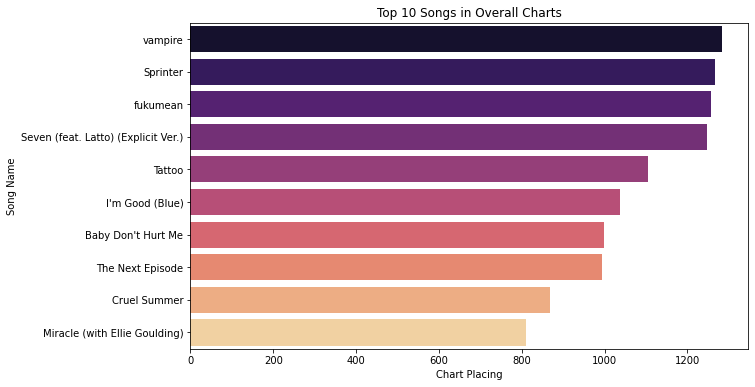

Top 10 Songs in Overall Charts:
1. vampire | by Olivia Rodrigo
2. Sprinter | by Dave, Central Cee
3. fukumean | by Gunna
4. Seven (feat. Latto) (Explicit Ver.) | by Latto, Jung Kook
5. Tattoo | by Loreen
6. I'm Good (Blue) | by Bebe Rexha, David Guetta
7. Baby Don't Hurt Me | by David Guetta, Anne-Marie, Coi Leray
8. The Next Episode | by Dr. Dre, Snoop Dogg
9. Cruel Summer | by Taylor Swift
10. Miracle (with Ellie Goulding) | by Calvin Harris, Ellie Goulding


In [0]:
rdd_mapped = music_rdd.map(lambda row: (row["track_name"], 
                                       (row["in_spotify_charts"] + row["in_apple_charts"] + 
                                        row["in_deezer_charts"] + row["in_shazam_charts"]), 
                                       row["artist(s)_name"]))

# sort by chart presence in descending order and take the top 10
top10_chart_data = rdd_mapped.sortBy(lambda x: x[1], ascending=False).take(10)
# each entry is a tuple containing track name, chart counts, and artist(s)
track_names = [x[0] for x in top10_chart_data]
chart_counts = [x[1] for x in top10_chart_data]
artists = [x[2] for x in top10_chart_data]

plt.figure(figsize=(10, 6))
sns.barplot(x=chart_counts, y=track_names, palette="magma")
plt.xlabel("Chart Placing")
plt.ylabel("Song Name")
plt.title("Top 10 Songs in Overall Charts")
plt.show()

# Print the results
print("Top 10 Songs in Overall Charts:")
for idx, (track_name, chart_count, artist) in enumerate(top10_chart_data):
    print(f"{idx + 1}. {track_name} | by {artist}")


3. Top 10 Songs in Overall Playlists - bigger engagement



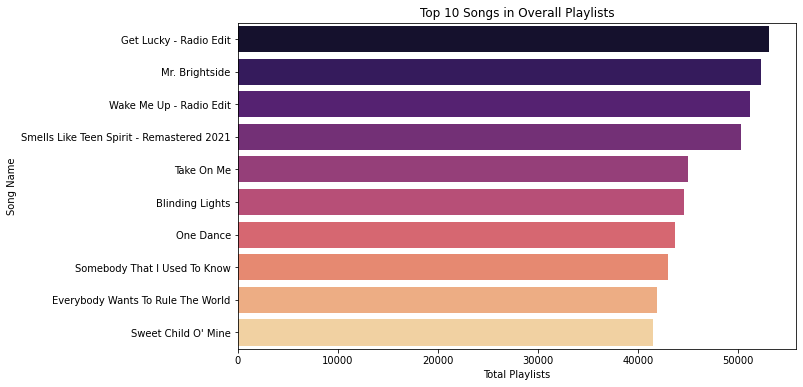

Top 10 Songs in Overall Playlists:
1. Get Lucky - Radio Edit by Pharrell Williams, Nile Rodgers, Daft Punk: 53101 playlists
2. Mr. Brightside by The Killers: 52285 playlists
3. Wake Me Up - Radio Edit by Avicii: 51202 playlists
4. Smells Like Teen Spirit - Remastered 2021 by Nirvana: 50256 playlists
5. Take On Me by a-ha: 44961 playlists
6. Blinding Lights by The Weeknd: 44571 playlists
7. One Dance by Drake, WizKid, Kyla: 43690 playlists
8. Somebody That I Used To Know by Gotye, Kimbra: 43015 playlists
9. Everybody Wants To Rule The World by Tears For Fears: 41852 playlists
10. Sweet Child O' Mine by Guns N' Roses: 41459 playlists


In [0]:
rdd_mapped = music_rdd.map(lambda row: (row["track_name"], 
                                       (row["in_spotify_playlists"] + row["in_apple_playlists"] + row["in_deezer_playlists"]), 
                                       row["artist(s)_name"]))

# sort by overall playlist presence in descending order and take the top 10
top_songs_playlists_data = rdd_mapped.sortBy(lambda x: x[1], ascending=False).take(10)
# each entry is a tuple containing track name, total playlist counts, and artist(s)
track_names = [x[0] for x in top_songs_playlists_data]
total_playlists = [x[1] for x in top_songs_playlists_data]
artist_names = [x[2] for x in top_songs_playlists_data]

plt.figure(figsize=(10, 6))
sns.barplot(x=total_playlists, y=track_names, palette="magma")
plt.xlabel("Total Playlists")
plt.ylabel("Song Name")
plt.title("Top 10 Songs in Overall Playlists")
plt.show()

print("Top 10 Songs in Overall Playlists:")
for index, (track_name, playlists, artist) in enumerate(top_songs_playlists_data):
    print(f"{index + 1}. {track_name} by {artist}: {playlists} playlists")


In [0]:
# unpersist from memory/disk
rdd_mapped.unpersist()

Out[32]: PythonRDD[410] at RDD at PythonRDD.scala:58

##### 2.3.3. Stream Analysis

1. Average and Top Streams

In [0]:
#approxQuantile computes approximate quantiles for a column, with a relative error tolerance (0.01)
percentile_threshold = music.approxQuantile("streams", [0.8], 0.01)[0]
print(f"The 80th percentile threshold is {percentile_threshold} streams.")

The 80th percentile threshold is 782369383.0 streams.


In [0]:
# filter out rows where streams are 0 
histogram_data = (
    music.filter(F.col("streams") != 0)
    .select("streams")
    .rdd.flatMap(lambda x: x) #convert dataFrame col into an RDD, and flatten it to a 1D structure
    .histogram(50)) 

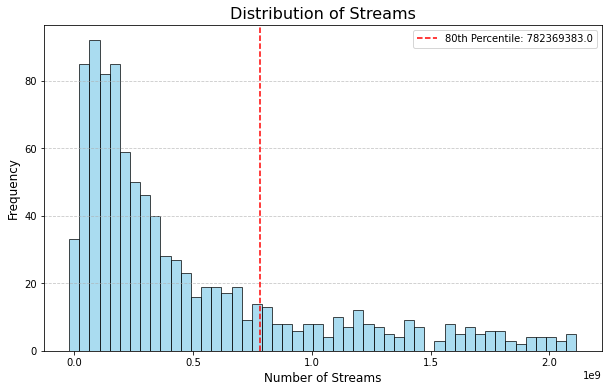

In [0]:
plt.figure(figsize=(10, 6))
plt.bar(
    histogram_data[0][:-1],  # Bin edges (excluding the last edge)
    histogram_data[1],       # Counts
    width=(histogram_data[0][1] - histogram_data[0][0]), 
    color="skyblue",
    edgecolor="black",
    alpha=0.7)   # transparency level of the bars
    
plt.axvline(percentile_threshold, color="red", linestyle="--", label=f"80th Percentile: {percentile_threshold}")
plt.title("Distribution of Streams", fontsize=16)
plt.xlabel("Number of Streams", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


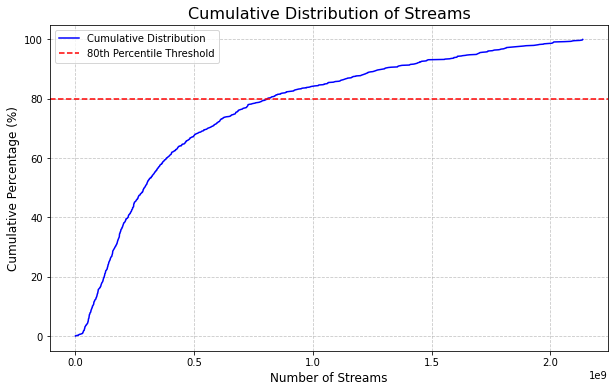

In [0]:
cumulative_data = music.filter(F.col("streams") != 0).select("streams")

# cumulative percentage using percent_rank() over an ordered window by streams
cumulative_data = cumulative_data.withColumn(
    "cumulative_percent", F.percent_rank().over(Window.orderBy("streams")) * 100)

# collect results into a list of rows for plotting
cumulative_values = cumulative_data.select("streams", "cumulative_percent").rdd.collect()

streams = [row["streams"] for row in cumulative_values]
cumulative_percent = [row["cumulative_percent"] for row in cumulative_values]

plt.figure(figsize=(10, 6))
plt.plot(streams, cumulative_percent, color="blue", label="Cumulative Distribution")
plt.axhline(y=80, color="red", linestyle="--", label="80th Percentile Threshold")
plt.title("Cumulative Distribution of Streams", fontsize=16)
plt.xlabel("Number of Streams", fontsize=12)
plt.ylabel("Cumulative Percentage (%)", fontsize=12)
plt.legend()
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.show()

##### 2.3.4. Time-Based Analysis

1. Song Releases Evolution

In [0]:
# set Spark to use the legacy time parser policy to handle datetime parsing - ensures compatibility with older versions of Spark and avoids errors when working with non-zero-padded or non-standard datetime formats, which might otherwise be misinterpreted by the default parsing behavior in Spark 3.0+.
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

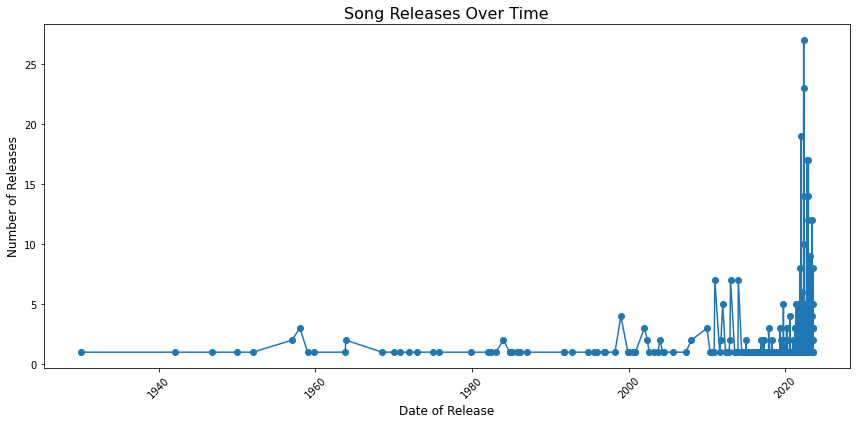

In [0]:
# create a `release_date` column by combining year, month, and day, converting it into a proper date format ('yyyy-MM-dd')
music = music.withColumn(
    "release_date",
    F.to_date(
        F.concat_ws("-", F.col("released_year"), F.col("released_month"), F.col("released_day")), 
        "yyyy-MM-dd"))

# group by 'release_date' to count the number of songs released on each date
release_counts = music.groupBy("release_date").agg(F.count("*").alias("count"))

release_counts_data = release_counts.collect()
release_counts_data_sorted = sorted(release_counts_data, key=lambda row: row['release_date'])

release_dates = [row['release_date'] for row in release_counts_data_sorted]
counts = [row['count'] for row in release_counts_data_sorted]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(release_dates, counts, marker='o')
plt.title("Song Releases Over Time", fontsize=16)
plt.xlabel("Date of Release", fontsize=12)
plt.ylabel("Number of Releases", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


From the provided graph, a clear and continuous timeline of song releases is shown, depicting a significant increase from 2010 onwards, with a peak around 2022 as is verified below.

2. Most/Least Common Release Years and Months

In [0]:
year_counts = music.groupBy("released_year").agg(F.count("*").alias("count"))

best_year = year_counts.agg(F.max("count").alias("best_count")).first()  
worst_year = year_counts.agg(F.min("count").alias("worst_count")).first()

# actual year values corresponding to the best and worst counts
best_year_value = year_counts.filter(F.col("count") == best_year["best_count"]).first()
worst_year_value = year_counts.filter(F.col("count") == worst_year["worst_count"]).first()

month_counts = music.groupBy("released_month").agg(F.count("*").alias("count"))

best_month = month_counts.agg(F.max("count").alias("best_count")).first()
worst_month = month_counts.agg(F.min("count").alias("worst_count")).first()

# actual month values corresponding to the best and worst counts
best_month_value = month_counts.filter(F.col("count") == best_month["best_count"]).first()
worst_month_value = month_counts.filter(F.col("count") == worst_month["worst_count"]).first()

# dict for viewer simplicity
month_dict = {
    "1": "January", "2": "February", "3": "March", "4": "April",
    "5": "May", "6": "June", "7": "July", "8": "August",
    "9": "September", "10": "October", "11": "November", "12": "December"}

print(f"Most common release year: {best_year_value['released_year']} with {best_year_value['count']} releases")
print(f"Least common release year: {worst_year_value['released_year']} with {worst_year_value['count']} releases")
best_month_name = month_dict.get(str(best_month_value['released_month']), 'Unknown')
worst_month_name = month_dict.get(str(worst_month_value['released_month']), 'Unknown')
print(f"Most common release month: {best_month_name} with {best_month_value['count']} releases")
print(f"Least common release month: {worst_month_name} with {worst_month_value['count']} releases")

Most common release year: 2022 with 402 releases
Least common release year: 2007 with 1 releases
Most common release month: January with 134 releases
Least common release month: August with 46 releases


Since January 2022 is the most prominent date, we decided to look further into that period of time.

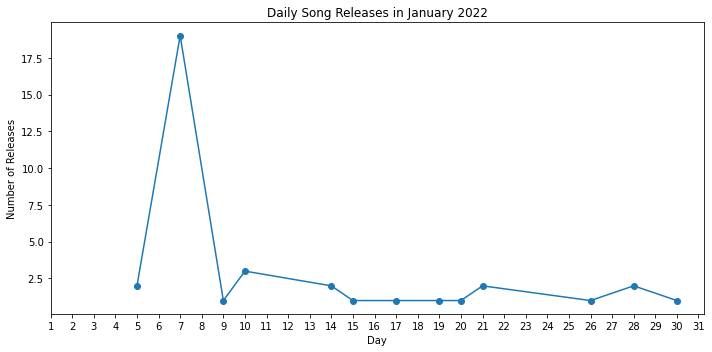

In [0]:
january_2022 = music.filter(
    (F.col("released_year") == "2022") & (F.col("released_month") == "1"))

daily_release_count = january_2022.groupBy("released_day").agg(F.count("*").alias("count"))
# order by 'released_day' to maintain chronological order
daily_release_count = daily_release_count.orderBy("released_day")

daily_release_count_data = daily_release_count.rdd.map(lambda row: (row['released_day'], row['count'])).collect()

# separate collected data into 2 lists: days and counts
days, counts = zip(*daily_release_count_data)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(days, counts, marker='o')
plt.title("Daily Song Releases in January 2022")
plt.xlabel("Day")
plt.ylabel("Number of Releases")
plt.xticks(range(1, 32))  # Days of January
plt.tight_layout()
plt.show()

There was a significant peak of song releases on the 7th of January 2022, which made us look further into that date, but no conclusions were reached. It is possible to be a mere coincidence that most artists wanted to release music right at the beginning of a new year.

##### 2.3.5. Platform Comparison

1. Spotify, Apple, and Deezer comparison


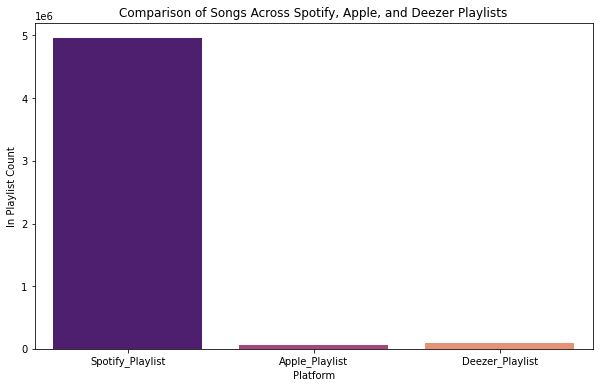

In [0]:
platform_comparison = music.agg(
    F.sum("in_spotify_playlists").alias("Spotify_Playlist"),
    F.sum("in_apple_playlists").alias("Apple_Playlist"),
    F.sum("in_deezer_playlists").alias("Deezer_Playlist"))

# get 1st row (since it's a single row aggregation)
platform_comparison_data = platform_comparison.first().asDict()

# separate the platform names (keys) and counts (values) from the dict
platform_names = list(platform_comparison_data.keys())
counts = list(platform_comparison_data.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=platform_names, y=counts, palette="magma")
plt.xlabel("Platform")
plt.ylabel("In Playlist Count")
plt.title("Comparison of Songs Across Spotify, Apple, and Deezer Playlists")
plt.show()


From comparing the amount of songs present across playlists in these platforms, we concluded that Spotify is the most present one, followed by Deezer, and lastly Apple.

##### 2.3.6. Correlations 

Evaluating correlations between the song's popularity in streams, to its musical attributes such as bmp, danceability, valence, energy, acousticness, instrumentalness, liveness and speechiness.

In [0]:
numerical_columns = [
    "streams", "danceability_%", "energy_%", "valence_%", 
    "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]

# VectorAssembler to combine numerical columns into a single vector column for ml 
vector_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
music_vectorized = vector_assembler.transform(music)

spearman_matrix = Correlation.corr(music_vectorized, "features", "spearman").head()[0]
correlation_matrix = np.array(spearman_matrix.toArray())

# a list of tuples representing feature pairs and their correlation values
rows = []
for i, row in enumerate(correlation_matrix):
    for j, value in enumerate(row):
        rows.append(
            (numerical_columns[i], numerical_columns[j], float(value)))  # add feature pair and correlation value

# schema for the DataFrame that will hold the correlation results
schema = StructType([
    StructField("feature1", StringType(), True),
    StructField("feature2", StringType(), True),
    StructField("correlation", DoubleType(), True)])

correlation_df = spark.createDataFrame(rows, schema=schema)
display(correlation_df)

feature1,feature2,correlation
streams,streams,1.0
streams,danceability_%,-0.08063493478970514
streams,energy_%,-0.033201632053135095
streams,valence_%,-0.0411643542056086
streams,acousticness_%,-0.059042936694334844
streams,instrumentalness_%,-0.003299633392158061
streams,liveness_%,-0.05869192365641572
streams,speechiness_%,-0.10580965200496602
danceability_%,streams,-0.08063493478970514
danceability_%,danceability_%,1.0


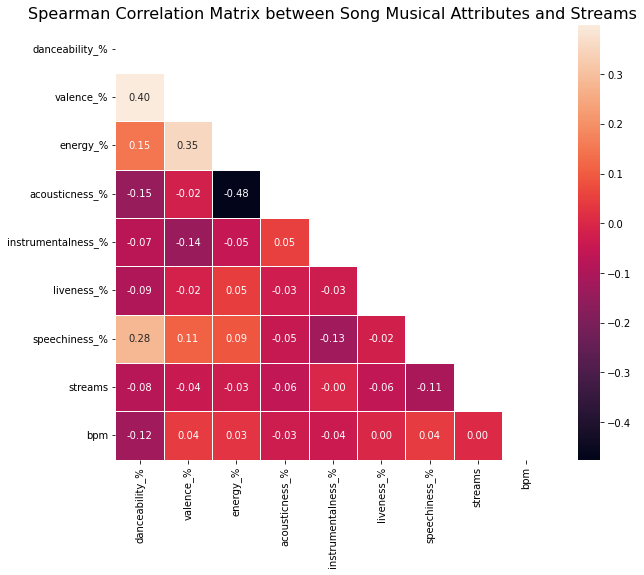

In [0]:
columns_to_correlate = [col for col in music.columns if col.endswith('%')]  + ["streams", "bpm"]

# convert the required columns to Pandas DataFrame for correlation calculation
# using pandas library isn't ideal for large datasets, so here we have not used big data safe functionality 
music_pd = music.select(columns_to_correlate).toPandas()
corr_matrix = music_pd.corr(method='spearman')

# upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", mask=mask, cbar=True, square=True, linewidths=0.5)
plt.title("Spearman Correlation Matrix between Song Musical Attributes and Streams", fontsize=16)
plt.show()


- Acousticness_% and Energy_%: There is a moderate negative correlation (-0.48), implying that more acoustic tracks tend to be less energetic.
- Danceability_% and Valence_%: These have a moderately positive correlation (0.40), suggesting that songs with higher danceability are often associated with a more positive mood or tone.
- Energy_% and Valence_%: They have a smaller positive correlation (0.35), indicating a slight tendency for higher-energy songs to also have a positive tone.
- Speechiness_% and Danceability_%: A small positive correlation (0.28) suggests that songs with higher speech-like qualities might be slightly more danceable.
- Other correlations between features are relatively weak or negligible, as seen in the low absolute values (close to 0).

In regards to streams, we found that there weren't very strong correlations between streams and the attributes. Nevertheless, we decided to look further into a prediction of a song's popularity based on its features. 

## 3. Modelling

Predict song popularity (popular if it's higher above a certain threshold of streams calculated earlier) based on attributes and song style metrics.

To streamline preprocessing and model training, we utilize Spark Pipelines, integrating hyperparameter tuning with cross-validation for both Logistic Regression, Random Forest and Gradient Boost Trees models.

##### 3.1. Feature Transformation

Here, we applied feature transformation to convert our categorical variables into a suitable format for the model.

In [0]:
# StringIndexer and OneHotEncoder for 'key', and 'mode'
indexer_mode = StringIndexer(inputCol="mode", outputCol="mode_binary").fit(music)
music = indexer_mode.transform(music)

##### 3.2. Feature Selection


We kept only the variables usefull for our prediction.

In [0]:

columns_to_drop = ["track_name", "released_year", "released_month", "released_day", "release_date","in_spotify_playlists","in_spotify_charts", "in_apple_playlists", "in_apple_charts", "in_deezer_playlists", "in_deezer_charts", "in_shazam_charts", "artist(s)_name", "cover_url", "key", "mode"]

music_modelling = music.drop(*columns_to_drop)
music_modelling.display()

artist_count,streams,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,mode_binary
2,141381703,125,80,89,83,31,0,8,4,0.0
1,133716286,92,71,61,74,7,0,10,4,0.0
1,140003974,138,51,32,53,17,0,31,6,0.0
1,800840817,170,55,58,72,11,0,11,15,0.0
1,303236322,144,65,23,80,14,63,11,6,1.0
2,183706234,141,92,66,58,19,0,8,24,0.0
2,725980112,148,67,83,76,48,0,8,3,1.0
1,58149378,100,67,26,71,37,0,11,4,0.0
1,95217315,130,85,22,62,12,0,28,9,1.0
2,553634067,170,81,56,48,21,0,8,33,1.0


We used the VectorAssembler to combine multiple feature columns into a single vector column, features_assembled. This step is critical for preparing data for Spark machine learning models, which require vectorized input characteristics. 

In [0]:
# VectorAssembler for feature aggregation
feature_cols = ["artist_count", "bpm", "danceability_%", "valence_%", "energy_%", 
                "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%", "mode_binary"]
                
assembler = MF.VectorAssembler(inputCols=feature_cols, outputCol="features_assembled")

##### 3.3. Scaling features

We used the MinMax scaler because most of the variables are percentages, making it the most suitable scaling solution for this dataset.

In [0]:
scaler = MF.MinMaxScaler(inputCol="features_assembled", outputCol="features")

##### 3.4. Begin Pipeline 

In [0]:
spotify_pipeline = Pipeline(  
    stages=[indexer_mode, assembler,scaler])

##### 3.5. Defining Target

Our target variable, representing popular songs, will identify songs above the 80th percentile, meaning only those in the top 20% of streams are classified as popular.

In [0]:
music_modelling = music_modelling.withColumn("popularity_label", 
                         when(music_modelling["streams"] > 703301727.0, 1).otherwise(0))

music_modelling = music_modelling.drop("streams")

In [0]:
music_modelling.display()

artist_count,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,mode_binary,popularity_label
2,125,80,89,83,31,0,8,4,0.0,0
1,92,71,61,74,7,0,10,4,0.0,0
1,138,51,32,53,17,0,31,6,0.0,0
1,170,55,58,72,11,0,11,15,0.0,1
1,144,65,23,80,14,63,11,6,1.0,0
2,141,92,66,58,19,0,8,24,0.0,0
2,148,67,83,76,48,0,8,3,1.0,1
1,100,67,26,71,37,0,11,4,0.0,0
1,130,85,22,62,12,0,28,9,1.0,0
2,170,81,56,48,21,0,8,33,1.0,0


##### 3.6. Model training

We split the dataset into training and testing sets with a 70-30 ratio. We use caching to store the train and test datasets in memory, which can speed up the processing of subsequent operations. This is especially helpful when working with large datasets, as it avoids recomputing the same data multiple times.

In [0]:
train, test = music_modelling.randomSplit([0.7, 0.3], 42) 
train.cache()
test.cache()

Out[53]: DataFrame[artist_count: int, bpm: int, danceability_%: int, valence_%: int, energy_%: int, acousticness_%: int, instrumentalness_%: int, liveness_%: int, speechiness_%: int, mode_binary: double, popularity_label: int]

3.6.1. Logistic Regression

In [0]:
lr = LogisticRegression(featuresCol="features", labelCol="popularity_label",predictionCol="prediction")

In [0]:
lr_evaluator = BinaryClassificationEvaluator(labelCol='popularity_label', metricName='areaUnderROC')


In [0]:
spotify_pipeline.setStages(
    [indexer_mode,
     assembler,
     scaler,
     lr])

Out[56]: Pipeline_f9d28e2cc34a

In [0]:
spotify_pipeline_model = spotify_pipeline.fit(train)
lr_results = spotify_pipeline_model.transform(test)

Assessment

In [0]:
def evaluate_model(model_results, label_col="popularity_label", metric_name="areaUnderROC"):
    evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName=metric_name)
    accuracy = evaluator.evaluate(model_results)
    return accuracy

In [0]:
lr_accuracy = evaluate_model(lr_results)
print(f"Logistic Regression AUC = {lr_accuracy}")

Logistic Regression AUC = 0.5671531302876479


In [0]:
def plot_roc_curve(model_results, label_col="popularity_label", prob_col="probability"):
    # extract predicted probabilities and actual labels from the model results
    predictions_and_labels = model_results.select(prob_col, label_col).rdd.map(
        lambda row: (row[prob_col][1], row[label_col]))  # extract 2nd value of the probab (prob of the positive class)

    # thresholds (0.0 - 1.0 in steps of 0.1), for calculating the ROC curve at different levels of classification confidence
    thresholds = np.arange(0.0, 1.1, 0.1)  
    tpr_values = []   # True Positive Rate (TPR) 
    fpr_values = []   # False Positive Rate (FPR)
    
    # loop through each threshold and calculate TPR and FPR
    for threshold in thresholds:
        # apply threshold to classify predictions: 1 if probability >= threshold, else 0
        prediction_labels = predictions_and_labels.map(
            lambda x: (1 if x[0] >= threshold else 0, x[1]))

        # calculate the number of True Positives, False Positives, False Negatives, and True Negatives
        tp = prediction_labels.filter(lambda x: x[0] == 1 and x[1] == 1).count()
        fp = prediction_labels.filter(lambda x: x[0] == 1 and x[1] == 0).count()
        fn = prediction_labels.filter(lambda x: x[0] == 0 and x[1] == 1).count()
        tn = prediction_labels.filter(lambda x: x[0] == 0 and x[1] == 0).count()

        # calculate the True Positive Rate (TPR) and False Positive Rate (FPR) for current threshold
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # Avoid division by zero
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Avoid division by zero

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_values, tpr_values, color="green", lw=2, label="Model ROC Curve")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1, label="Random Guess")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

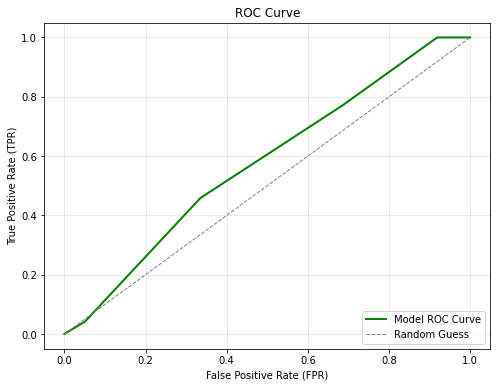

In [0]:
plot_roc_curve(lr_results)

3.6.2. Random Forest

In [0]:
rf = RandomForestClassifier(featuresCol="features", labelCol="popularity_label", numTrees=20, maxDepth=10, seed=42)

In [0]:
rf_evaluator = BinaryClassificationEvaluator(labelCol='popularity_label', metricName='areaUnderROC')


In [0]:
spotify_pipeline.setStages([
    indexer_mode,
    assembler,
    scaler,
    rf])


Out[64]: Pipeline_f9d28e2cc34a

In [0]:
spotify_pipeline_rf_model = spotify_pipeline.fit(train)
rf_results = spotify_pipeline_rf_model.transform(test)

Assessment

In [0]:
rf_accuracy = evaluate_model(rf_results)
print(f"Random Forest AUC = {rf_accuracy}")

Random Forest AUC = 0.5646150592216579


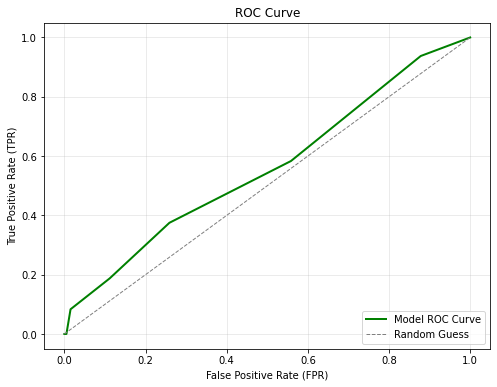

In [0]:
plot_roc_curve(rf_results)

3.6.3. Gradient Boost Trees

In [0]:
gbt = GBTClassifier(labelCol="popularity_label", featuresCol="features", maxIter=100)

In [0]:
gbt_evaluator = BinaryClassificationEvaluator(labelCol='popularity_label', metricName='areaUnderROC')


In [0]:
spotify_pipeline.setStages([
    indexer_mode,
    assembler,
    scaler,
    gbt])

Out[70]: Pipeline_f9d28e2cc34a

In [0]:
spotify_pipeline_gbt_model = spotify_pipeline.fit(train)
gbt_results = spotify_pipeline_gbt_model.transform(test)

Assessment

In [0]:
gbt_accuracy = evaluate_model(gbt_results)
print(f"Gradient-Boosted Trees AUC = {gbt_accuracy}")

Gradient-Boosted Trees AUC = 0.5500211505922166


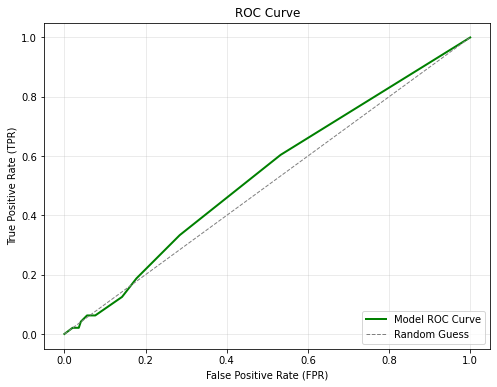

In [0]:
plot_roc_curve(gbt_results)

##### 3.7. Crossvalidation Hyperparameter Tuning


In order to improve the model's accuracy, we decided to fine-tune some components of the training process, particularly how Spark builds the fitted model, by leveraging the process of cross-validation. 
We utilize the ParamGridBuilder to specify the hyperparameters that we wish to test. This tool allows us to create a parameter grid, which is required for constructing a parameter map to test various hyperparameter combinations.

We do not recommend re-running the following cells because certain searches may take a while.

Logistic Regression

In [0]:
# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-validation setup
crossval = CrossValidator(
    estimator=Pipeline(stages=[indexer_mode, assembler, scaler, lr]),
    estimatorParamMaps=paramGrid,
    evaluator=lr_evaluator,
    numFolds=3,
    seed=13)

cv_lr_model = crossval.fit(train)
# save the cross-validation model to avoid re-running
cv_lr_model.save("/dbfs/mnt/my_bucket/saved_models/cv_lr_model")

# Evaluate the best model
cv_lr_results = cv_lr_model.transform(test)
cv_lr_accuracy = lr_evaluator.evaluate(cv_lr_results)
print(cv_lr_model.avgMetrics)
print(f"Logistic Regression (Cross-Validated) AUC = {cv_lr_accuracy}")

[0.5552037510526521, 0.5552037510526521, 0.5552037510526521]
Logistic Regression (Cross-Validated) AUC = 0.5671531302876479


In [0]:
best_lr_model = cv_lr_model.bestModel.stages[-1]

print("Best Regularization Parameter (regParam):", best_lr_model.getRegParam())
print("Best ElasticNet Parameter (elasticNetParam):", best_lr_model.getElasticNetParam())

# Coefficients and Intercept
print("Coefficients:", best_lr_model.coefficients)
print("Intercept:", best_lr_model.intercept)


Best Regularization Parameter (regParam): 0.0
Best ElasticNet Parameter (elasticNetParam): 0.0
Coefficients: [-3.0265809080032473,-0.305201295258043,-0.9432324067476925,0.014336185498262152,0.10744028346554874,0.1394291563358173,-0.9871982922890218,-0.009473215531242044,-1.8923642613476095,-0.08335725770270243]
Intercept: -0.07310195519920826


Random Forest

In [0]:
# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 30]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Cross-validation setup
crossval = CrossValidator(
    estimator=Pipeline(stages=[indexer_mode, assembler, scaler, rf]),
    estimatorParamMaps=paramGrid,
    evaluator=rf_evaluator,
    numFolds=2,
    seed=13,
    parallelism=4)

cv_rf_model = crossval.fit(train)
cv_rf_model.save("/dbfs/mnt/my_bucket/saved_models/cv_rf_model")
# Evaluate the best model
cv_rf_results = cv_rf_model.transform(test)
cv_rf_accuracy = rf_evaluator.evaluate(cv_rf_results)
print(cv_rf_model.avgMetrics)

print(f"Random Forest (Cross-Validated) AUC = {cv_rf_accuracy}")

[0.5337677826049917, 0.5321999988514228, 0.563043839271955, 0.5652578292276488]
Random Forest (Cross-Validated) AUC = 0.5943316412859552


In [0]:
best_rf_model = cv_rf_model.bestModel.stages[-1]

# Retrieve hyperparameters
print("Best Number of Trees (numTrees):", best_rf_model.getNumTrees)
print("Best Maximum Depth (maxDepth):", best_rf_model.getOrDefault("maxDepth"))
print("Feature Importances:", best_rf_model.featureImportances)


Best Number of Trees (numTrees): 30
Best Maximum Depth (maxDepth): 10
Feature Importances: (10,[0,1,2,3,4,5,6,7,8,9],[0.05358197486589407,0.1549159135399244,0.11677306951064173,0.12084667157596843,0.14151758576986354,0.11054022884006211,0.017531236270635374,0.13532292904920099,0.11646812886351117,0.03250226171429821])


Gradient Boost Trees

In [0]:
# Define the parameter grid for tuning the model
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .addGrid(gbt.subsamplingRate, [0.8, 1.0]) \
    .build()

# Cross-validation setup
crossval = CrossValidator(
    estimator=Pipeline(stages=[indexer_mode, assembler, scaler, gbt]),
    estimatorParamMaps=paramGrid,
    evaluator=gbt_evaluator,
    numFolds=2,
    seed=13,
    parallelism=4)

# Fit the model using cross-validation
cv_gbt_model = crossval.fit(train)

# save the cross-validation model to avoid re-running
cv_gbt_model.save("/dbfs/mnt/my_bucket/saved_models/cv_gbt_model")

# Evaluate the best model on the test set
cv_gbt_results = cv_gbt_model.transform(test)
cv_gbt_accuracy = gbt_evaluator.evaluate(cv_gbt_results)
print(cv_gbt_model.avgMetrics)  
print(f"Gradient Boosted Trees (Cross-Validated) AUC = {cv_gbt_accuracy}")

[0.5187456389964884, 0.5402943085135403, 0.5278325944154272, 0.534591515748427, 0.5243351174563609, 0.5356954059789176, 0.5401533446085314, 0.528355137154457, 0.5429440518544252, 0.5849822951632463, 0.5384438551606046, 0.5762975211792825, 0.5437200113709127, 0.5899603716986782, 0.5468670646486171, 0.5720673597372053]
Gradient Boosted Trees (Cross-Validated) AUC = 0.5524534686971235


In [0]:
best_gbt_model = cv_gbt_model.bestModel.stages[-1]

print("Best maxDepth:", best_gbt_model.getMaxDepth())
print("Best maxIter:", best_gbt_model.getMaxIter())
print("Best stepSize:", best_gbt_model.getStepSize())
print("Best subsamplingRate:", best_gbt_model.getSubsamplingRate())

Best maxDepth: 10
Best maxIter: 20
Best stepSize: 0.05
Best subsamplingRate: 1.0


##### 3.8. Model Comparison

The best model is Random Forest with an AUC score of 0.5943316412859552

## 4. Conclusion

In conclusion, the best model identified shows a AUC score of around 60%, which indicates that predicting a song's popularity based solely on its features is unreliable due to external and uncontrollable factors influencing popularity. However, the exploratory analysis provided valuable insights, revealing key attributes that are consistently found in popular songs, such as song characteristics like danceability and moderate valence, 1 to 2 artists perfoming the song, and so on. These findings illustrate the complexity of predicting popularity while also providing a better understanding of the factors that contribute to a song's overall success across streaming platforms.